In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFeatureExtractionSettings, ReasonableFeatureExtractionSettings
import tflscripts
import json
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from scipy.spatial.distance import cdist
import math
from scipy.spatial.distance import pdist, squareform


configuration = tflscripts.read_configuration()

/home/giotto/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [50]:
datasets_and_devices = [
    ['synergy-final-iter1', '128.237.254.195'],
    ['synergy-final-iter2', '128.237.248.186'],
    ['scott-final-iter1', '128.237.247.134'],
    ['scott-final-iter1', '128.237.248.186'],
    ['robotics-final', '128.237.246.127'],
    ['robotics-final', '128.237.247.134']
#     ['synergy-final-iter1', 'Matrix b827eb41f96f'],
#     ['synergy-final-iter2', 'Matrix b827ebe6e0f8'],
#     ['scott-final-iter1', 'Matrix b827ebe6e0f8'],
#     ['scott-final-iter1', 'Matrix b827eb41f96f'],
#     ['robotics-final', 'Matrix b827eb41f96f'],
#     ['robotics-final', 'Matrix b827eb96f31a'],
#     ['synergy-final-iter1', 'xdk_2'],
#     ['synergy-final-iter2', 'xdk_1'],
#     ['scott-final-iter1', 'xdk_3'],
#     ['scott-final-iter1', 'xdk_2'],
#     ['robotics-final', 'xdk_1'],
#     ['robotics-final', 'xdk_3'],
]

complete_df = []
for dataset, device in datasets_and_devices:
    dataset_path = '../datasets/' + dataset + '-complete/'
    df = pd.read_pickle(dataset_path + device + '.p')

    complete_df.append(df)

complete_df = pd.concat(complete_df)
complete_df = complete_df.reset_index()

In [51]:
def read_complete_dataset(dataset,
                          device,
                          sensor_streams,
                          activities,
                          complete_df,
                          anomaly_percentile=100):

    dataset_folder = '../datasets/'

    dataset_path = dataset_folder + dataset + '-complete/'
    df = pd.read_pickle(dataset_path + device + '.p')
    df = df.filter(regex=sensor_streams + '|label')

    value_columns = df.filter(regex=sensor_streams).columns

    mean = complete_df[value_columns].mean()
    std = complete_df[value_columns].std()
    df[value_columns] = df[value_columns].clip(mean - 2 * std, mean + 2 * std, axis=1)

#     null_df = df.loc[df.label == configuration['activities'].index('Null')]

#     null_mean = null_df[value_columns].mean()
#     null_std = null_df[value_columns].std()
    df[value_columns] = (df[value_columns] - mean) / std
    df = df.replace([np.inf, -np.inf, np.nan], 0)

    if anomaly_percentile < 100:
        anomalies = (df[value_columns] ** 2).sum(axis=1).apply(np.sqrt)
        df['anomalies'] = anomalies

#     df[value_columns] = StandardScaler().fit_transform(df[value_columns])

    activities_i = [configuration['activities'].index(a) for a in activities]
    df = df.loc[df.label.isin(activities_i)]
    df['label'] = [configuration['activities'][int(i)] for i in df['label']]

    if anomaly_percentile < 100:
        anomaly_threshold = np.percentile(df.anomalies.values, 100 - anomaly_percentile)
        print(anomaly_threshold)
        df = df.loc[df.anomalies > anomaly_threshold]

    return df

In [52]:
activities = [
    "Dishes",
    "Microwave",
    "Coffee",
#     "Null",
    "Kettle",
    "Chopping food",
#     "Conversation",
#     "Eating popcorn",
#     "Making popcorn in microwave",
    "Knocking",
#     "Phone vibrating"
]

tests = [
    ['synergy-final-iter1', '128.237.254.195'],
    ['synergy-final-iter2', '128.237.248.186'],
    ['scott-final-iter1', '128.237.247.134'],
    ['scott-final-iter1', '128.237.248.186'],
    ['robotics-final', '128.237.246.127'],
    ['robotics-final', '128.237.247.134'],
#     ['synergy-final-iter1', 'xdk_2'],
#     ['synergy-final-iter2', 'xdk_1'],
#     ['scott-final-iter1', 'xdk_3'],
#     ['scott-final-iter1', 'xdk_2'],
#     ['robotics-final', 'xdk_1'],
#     ['robotics-final', 'xdk_3'],
]

test_labels = [
    'Synergy, iteration 1, sink',
    'Synergy, iteration 2, sink',
    'Scott, right',
    'Scott, left',
    'Robotics, coffee',
    'Robotics, sink',
]

sensor_streams = 'MICROPHONE_sst'
all_features = []

for k, test in enumerate(tests):
    df = read_complete_dataset(anomaly_percentile=100,
                               activities=activities,
                               sensor_streams=sensor_streams,
                               complete_df=complete_df,
                               dataset=test[0],
                               device=test[1])
    features = extract_features(df,
                     column_id="label",
                     feature_extraction_settings=MinimalFeatureExtractionSettings())

    label = test_labels[k]
    features.index = [label + ' ' + str(activity) for activity in features.index]
    all_features.append(features)

features = pd.concat(all_features)
features[features.columns] = StandardScaler().fit_transform(features[features.columns])

Feature Extraction: 100%|██████████| 7/7 [00:00<00:00, 149.44it/s]


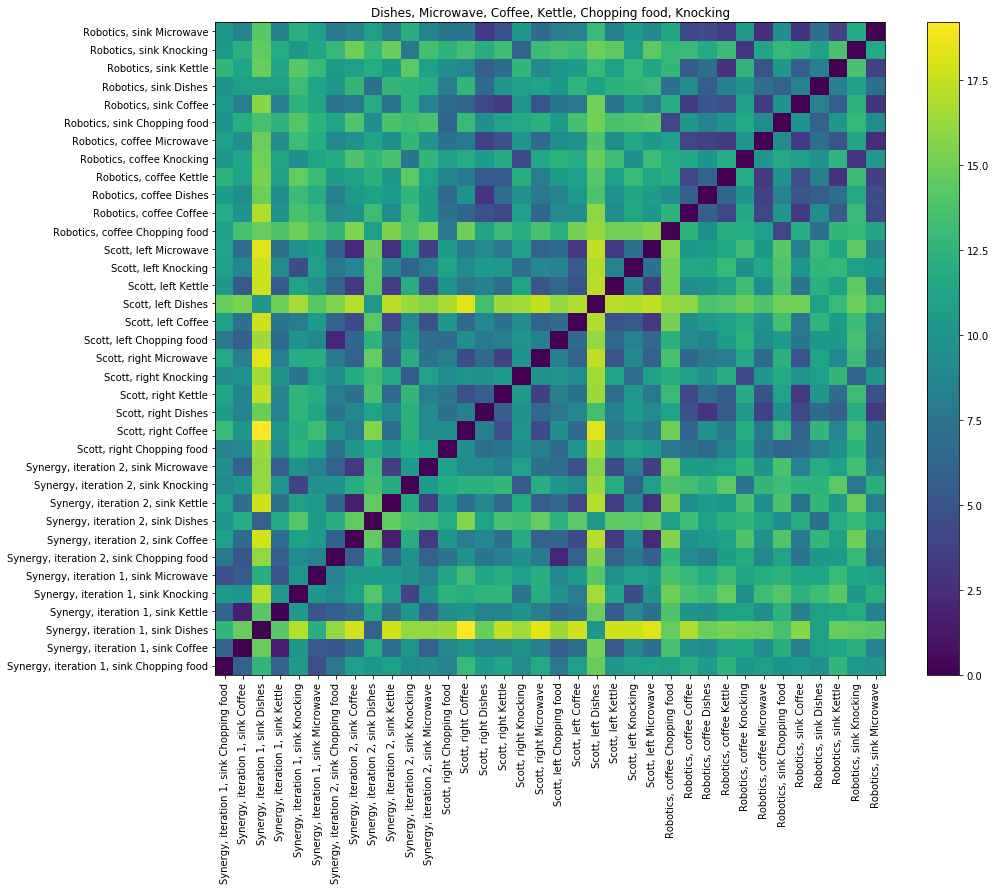

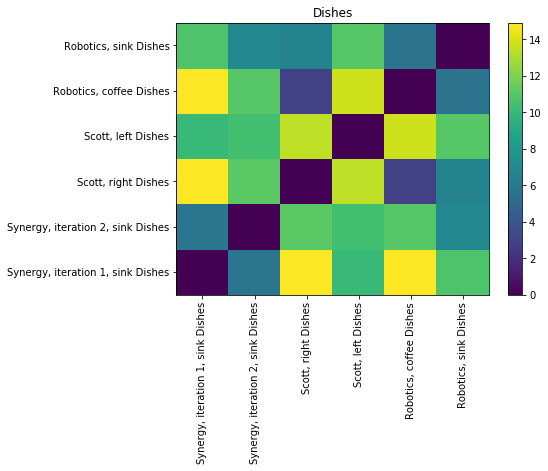

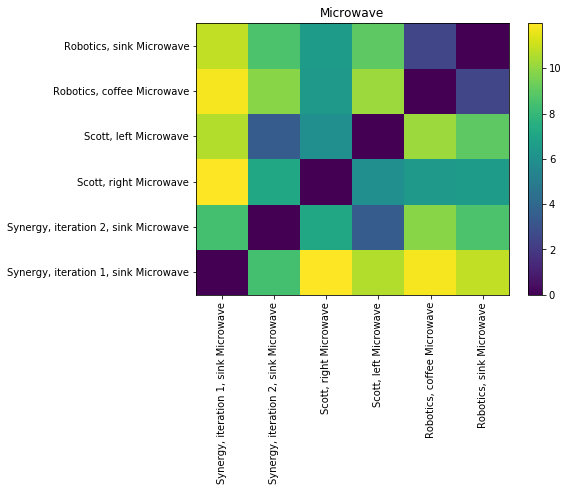

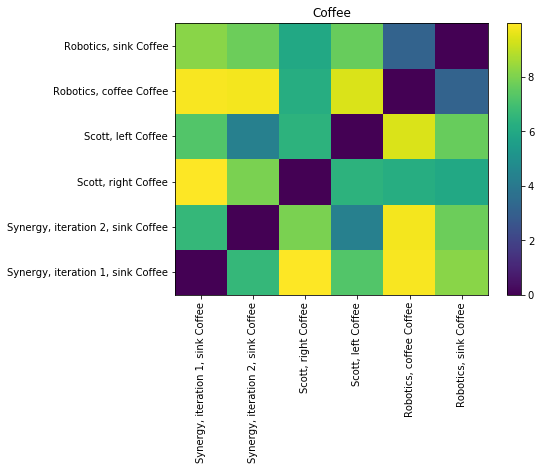

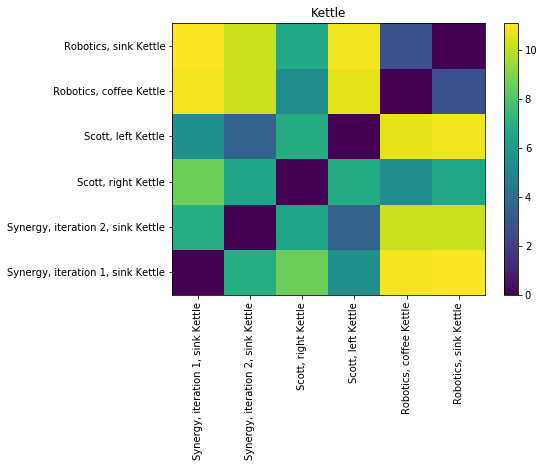

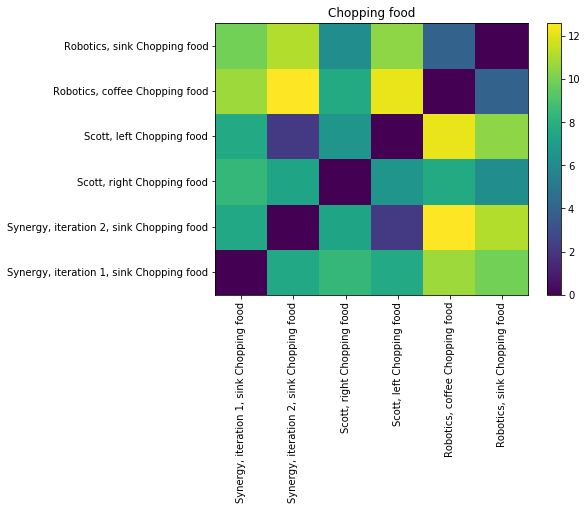

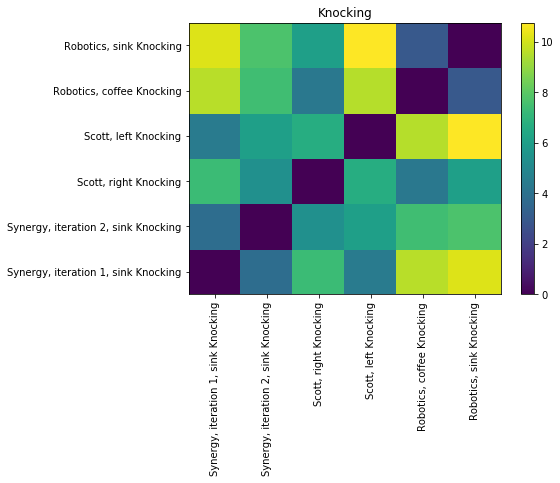

In [53]:
plt.rcParams["figure.figsize"] = (15, 12)
distances = pdist(features.values, metric='euclidean')
distances = pd.DataFrame(squareform(distances))
distances.index = features.index
distances.columns = features.index
plt.pcolormesh(distances, cmap='viridis')
plt.yticks(np.arange(0.5, len(distances.index), 1), distances.index)
plt.xticks(np.arange(0.5, len(distances.columns), 1), distances.columns, rotation='vertical')
plt.colorbar()
plt.title(', '.join(activities))
plt.show()

plt.rcParams["figure.figsize"] = (7, 5)
for activity in activities:
    activity_distances = distances.filter(regex=activity)
    activity_distances = activity_distances.loc[activity_distances.index.str.contains(activity)]
    plt.pcolormesh(activity_distances, cmap='viridis')
    plt.yticks(np.arange(0.5, len(activity_distances.index), 1), activity_distances.index)
    plt.xticks(np.arange(0.5, len(activity_distances.columns), 1), activity_distances.columns, rotation='vertical')
    plt.colorbar()
    plt.title(activity)
    plt.show()